#### Описание набора данных для исследования:

Данные, необходимые для поступления в университет с целью получения высшего образования

Источник - https://www.kaggle.com/datasets/akshaydattatraykhare/data-for-admission-in-the-university

Объем набора данных составляет  400 записей. Имя файла с исходными данными adm_data.csv.

#### Исходные данные содержат следующую информацию:

 - ```GRE Score``` — баллы GRE (Graduate Record Examinations, тест в аспирантуру, магистратуру США) (из 340);
 - ```TOEFL Score``` — баллы TOEFL (из 120);
 - ```University Rating``` — ретинг университета (из 5);
 - ```SOP``` — заявление о цели обучения (из 5)  (SOP - statement of purpose);
 - ```LOR``` — рекомендательное письмо (из 5) (LOR - Letter of Recommendation);
 - ```CGPA``` — совокупный средний балл бакалавра CGPA (из 10 );
 - ```Research``` —  опыт исследовательской работы (0 или 1 );
 - ```Chance of Admit``` —  Шанс поступления в ВУЗ (в диапазонеот 0 до 1);

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import preprocessing

import seaborn as sns

In [2]:
csv=pd.read_csv(r'adm_data.csv', index_col=['Serial No.'])

### Проверим качество как данных, так и самого файла

In [3]:
csv.columns 

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

Как видно, в файле есть дефекты: в двух колонках LOR и Chance of Admit присутствует завершающий пробел.

###### Теперь проверим качество самих данных.

Предикторами выспупают поля 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research'

Откликом будет поле 'Chance of Admit '

In [4]:
csv.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [5]:
csv.isnull().sum().sum()

0

Пропущенных значений нет. Явно нестандартных значений не видно. 
Более детально посмотрим на возможные аномалий с помощью графика boxplot.

<AxesSubplot:>

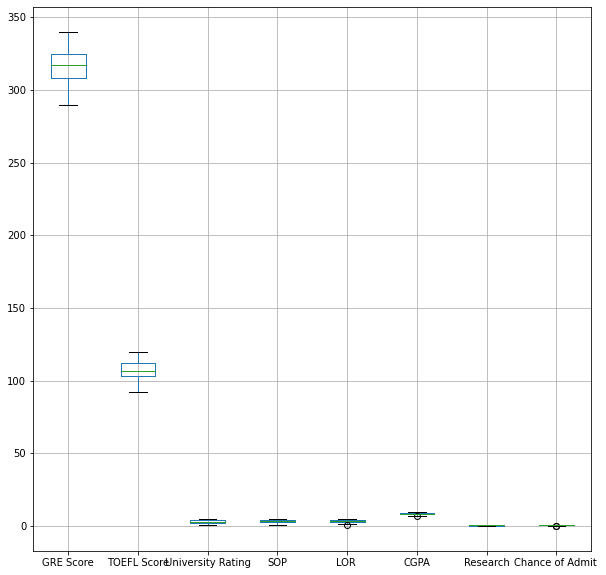

In [6]:
csv.boxplot(figsize=(10,10)) 

Данные имеют разные единицы измерения, поэтому для наглядности и сравнения стандартизуем их. 

Применим к данным линейную нормировку (MinMaxScaler) и построим по ним график boxplot.

<AxesSubplot:>

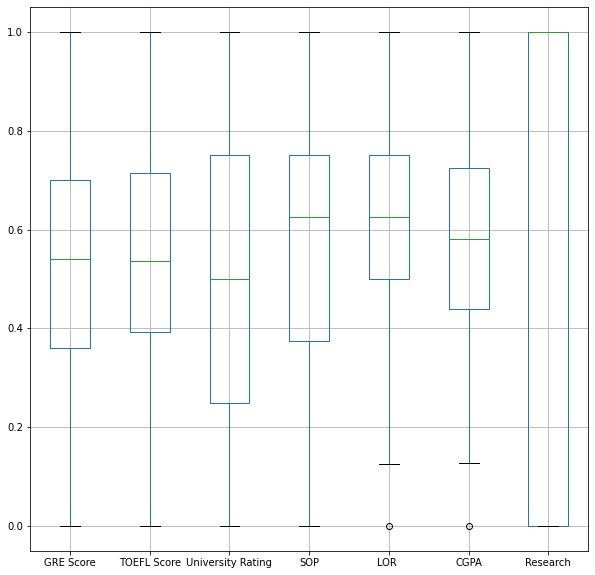

In [7]:
csv_x=csv[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research']]
stand = preprocessing.MinMaxScaler(copy=False)
csv_x_norm = stand.fit_transform(csv_x)
pd.DataFrame(csv_x_norm, index = csv_x.index,columns = csv_x.columns).boxplot(figsize=(10,10))

Хотя на графике видны выбросы (значения в LOR и CGPA), однако их минимальные значения из функции describe()) вполне допустимы как по смыслу, так и в границах заданных интервалов. Поэтому все исходные данные будем считать "чистыми".

### Уменьшение размерности данных

Так как у наших объектов  7 признаков, то нам сложно выявить какие-то общности внутри них. 
На интуитивном уровне мы можем предположить, что чем больше значения предикторов (баллы), тем выше отклик (вероятность поступления).
Для общего представления о наших объектах используем метод построения главных компонет (ГК) для уменьшения размерности. Отобразим результат на графике.

In [8]:
from sklearn.decomposition import PCA

x=csv_x # Предикторы
x=np.array(x) 
x=(x-x.min())/(x.max()-x.min()) # Выполним нормализацию данных вручную
x=x-x.mean(axis=0) # Выполним центрирование данных

y=csv['Chance of Admit '] # Отклики
y=np.array(y) 

Количество ГК сначала возьмем максимальным, равным количеству признаков, т.е. семь.

In [9]:
pca = PCA(n_components = x.shape[1], svd_solver = 'full') # Создание объекта класса PCA
X_full_transformed = pca.fit_transform(x)

Найдем долю объясненной дисперсии в зависимости от количества используемых ГК.

In [10]:
explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)
explained_variance

array([0.935, 0.989, 0.995, 0.997, 0.999, 1.   , 1.   ])

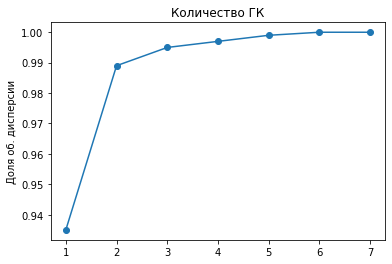

In [11]:
plt.plot(np.arange(1,8), explained_variance, marker='o')
plt.ylabel('Доля об. дисперсии')
plt.title('Количество ГК')
plt.show()

Уже на второй ГК доля объясненной дисперсии весьма велика 0.989, поэтому попробуем оставить две ГК.

In [12]:
pca = PCA(n_components = 2, svd_solver = 'full')
X_full_transformed = pca.fit_transform(x) # ndarray из объектов, где каждый объект описывается 2-мя ГК
X_full_transformed_DF=pd.DataFrame(X_full_transformed)

In [13]:
pca.components_ # "это вектор весов Фи"  

array([[-0.89819828, -0.4275918 , -0.06292448, -0.05114292, -0.04108918,
        -0.04030481, -0.02274241],
       [-0.43691217,  0.89218293,  0.07214279,  0.07189561,  0.0420899 ,
         0.02984636, -0.00902454]])

Изобразим oбъекты в виде точек на плоскости.

В силу того, что нам известны отклики (Шанс поступления "Chance of Admit"), отметим похожие цифры одинаковым цветом.


<function matplotlib.pyplot.show(close=None, block=None)>

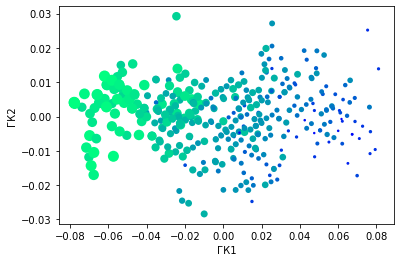

In [14]:
import math
plt.scatter(X_full_transformed[:, 0],
            X_full_transformed[:, 1], 
            c=y[:], 
            edgecolor='none',
            # для большей наглядности меняем не только цвет точек, но и их размер в зависимости от вероятности прямопропорционально  
            s=math.exp(5)**y,
            cmap='winter')
plt.xlabel('ГК1')
plt.ylabel('ГК2')
plt.show

На графике хорошо отделяется его левая часть. Середина и правая часть также условно выделяются, но что конкртетно там происходит - не понятно. Поэтому увеличим количество ГК до трех и построим 3-хмерный график.

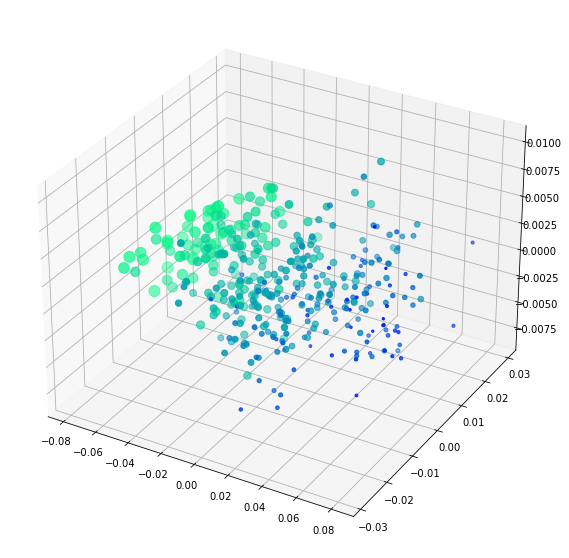

In [15]:
pca = PCA(n_components = 3, svd_solver = 'full')
X_full_transformed = pca.fit_transform(x) # ndarray из объектов, где каждый объект описывается 3-мя ГК
X_full_transformed_DF=pd.DataFrame(X_full_transformed)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
sequence_containing_x_vals = X_full_transformed[:, 0]
sequence_containing_y_vals = X_full_transformed[:, 1]
sequence_containing_z_vals = X_full_transformed[:, 2]
ax.scatter(sequence_containing_x_vals, 
           sequence_containing_y_vals, 
           sequence_containing_z_vals,
           c=y[:],
           s=math.exp(5)**y,
           cmap='winter')
plt.show()

Из графика можно предположить,что исходные данные условно разделяются на 4 группы. Их интерпретации будут рассмотрены ниже.
 - верхняя левая;
 - верхняя-средняя;
 - нижняя-средняя;
 - нижняя-правая.

### Постановка задачи

Вопросы, которые волнуют любого абитуриента и его родителя: 
- есть ли шансы поступить в ВУЗ?
- есть ли смысл напрягаться (тратить время, деньги и нервы) на подготовку к ВУЗу?

Метод МГК выдал нам графически некое предствление о возможных 3-4 группах (левая, центральные одна-две и правая) 

Хотя было бы понятнее для простого человека 3-хклассовое разбиение:
 - "звезды" 
 - "имеющие потенциал" (А ЗНАЧИТ НАДО ТРАТИТЬСЯ НА ПОДГОТОВКУ!)
 - "бесперспективные"
 
### Задача № 1 - распределить абитуриентов по группам в зависимости от их достижений и дать общее описание групп для того, чтобы абитуриент смог приблизительно оценить свое положение среди поступающих в ВУЗы.

##### Для определения адекватного числа групп абитуриентов (кластеров) применим метод кластеризации k-means:

In [16]:
from sklearn.cluster import KMeans

x=csv[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research']]
x=np.array(x) # Предикторы

y=csv['Chance of Admit ']
y=np.array(y) # Отклики

x=(x-x.min())/(x.max()-x.min())# Выполним линейную нормировку

В начале исследования построим избытоное количество кластеров, равное 10.

In [17]:
clasters = [1,2,3,4,5,6,7,8,9,10]
KMeans_method = [KMeans(n_clusters = i, random_state = 0).fit(x) for i in clasters]

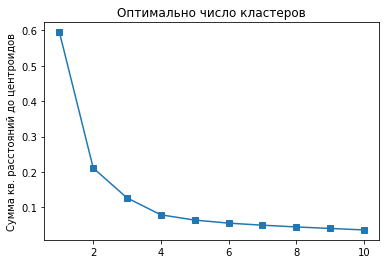

In [18]:
sum_SP = [j.inertia_ for j in KMeans_method]
plt.plot(clasters, sum_SP, marker='s')
plt.ylabel('Сумма кв. расстояний до центроидов')
plt.title('Оптимально число кластеров')
plt.show()

Из графика видно, что после разбиения на кластеры от 4 до 6 штук, объеткты перестают осбобо сильно менять свою принадлежность к кластерам. Поэтому выберем самый простой (для инерпертации) вариант - оставим 4 кластера.

In [19]:
KMeans_method_final = KMeans(n_clusters = 4, random_state = 0).fit(x) # оставим 4 класса
KMeans_method_final.labels_ # метод k-means раскидал наши оббъекты по классам 
print('Затрачено итераций: ', KMeans_method_final.n_iter_)

Затрачено итераций:  6


Сохраним результаты кластеризации в наш датасет, добавив их в новую колонку 'Y'.

In [20]:
csv['Y']=KMeans_method_final.labels_
#csv.to_csv('csv_KMeans.csv')

Для анализа сформированных кластеров используем средние значения признков каждого кластера (функция mean())

In [21]:
csv_KMeans=csv.groupby('Y')[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research','Chance of Admit ']].mean()
csv_KMeans=round(csv_KMeans.rename(index=lambda x: 'Claster '+ str(x)),2) # для удобства восприятия информации
csv_KMeans

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Y,,,,,,,,
Claster 0,323.23,109.98,3.52,3.73,3.68,8.85,0.80,0.78
Claster 1,312.08,104.80,2.57,3.06,3.21,8.35,0.31,0.67
Claster 2,299.55,99.92,2.11,2.54,2.72,7.90,0.18,0.55
Claster 3,333.92,116.52,4.48,4.48,4.36,9.44,0.97,0.92


Также покажем структуру сформированных кластеров

In [22]:
csv_KMeans_count=csv.groupby('Y')[['Chance of Admit ']].count()
csv_KMeans_count=csv_KMeans_count.rename(columns = {'Chance of Admit ':'Amount'})
csv_KMeans_count['Percent']=csv_KMeans_count['Amount']/csv_KMeans_count['Amount'].sum()*100
csv_KMeans_count=csv_KMeans_count.rename(index=lambda x: 'Claster '+ str(x))
csv_KMeans_count

,Amount,Percent
Y,,
Claster 0,126,31.50
Claster 1,140,35.00
Claster 2,71,17.75
Claster 3,63,15.75


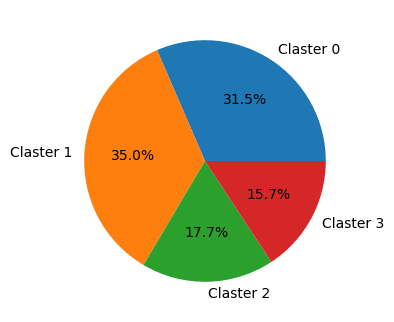

In [23]:
mpl.rcParams['figure.dpi'] = 100
xpie=csv_KMeans_count.index
ypie=round(csv_KMeans_count['Amount'],1)
plt.pie(ypie, labels=xpie, autopct='%.1f%%')
plt.show()

###  Из полученных данных кластеризации можно сделать следующий выводы:

 - ```Кластер № 3``` — шанс поступить в ВУЗ большой (ДА).
 - ```Кластер № 0``` — шанс поступить в ВУЗ сомнительный, (сорее ДА).
 - ```Кластер № 1``` — шанс поступить в ВУЗ сомнительный, (скорее НЕТ).
 - ```Кластер № 2``` — шанс поступить в ВУЗ очень низкий (НЕТ).

Кластер лидеров № 3 "ДА" довольно весомый - 15.7%, а в совокупности с кастером № 0 "скорее ДА" составляет почти половину - 47.2%
Значит конкуренция среди абитуриентов внушительная.

Абитуриенты из Третьего кластера могут поступить с очень большой вероятностью - средняя вероятность поступления 92%.

Абитуриенты из Нулевого кластера ("скорее ДА") упустив всего 0.59 (9.44-8.85) балла по CGPA уже проседают по верояттности поступления  на 13% (0.91-0.78). И Рейтинг ВУЗа у них сразу понижается (University Rating=3.5)

Абитуриенты из Первого кластера ("скорее НЕТ") также отстают на 0.5 (8.85-8.35) балла по CGPA от предыдущего класса 0.
Но у них дополнительно отмечатеся вялая научная деятельность - всего 31% из них учатсвует в исследованиях. 
Реййтинг ВУЗа у них еще болше снизился до 2.57.

Абитуриенты из Второго кластера ("НЕТ шансов") с наименьшими балалми (CGPA=7.9) практически не принимают участия в исследованиях (Research=0.18) 
И даже не смотря на то, что они и выбирают самые низкорейтинговые ВУЗы (University Rating=2.11), вероятнсть поступить даже в эти ВУЗы небольшая - 55%.
Также закономерно, что никто не торопится давать им Рекомендательные писма (LOR =2.7).

### Задача № 2 - При оценке своих возможность (ориентируясь на средние значения кластеров) как абитуриенту понять, на что он должен сделать бОльший упор в подготовке к поступлению в ВУЗ?
(необходимо проводить подобные оценки заблаговременно до выпуска из школы).

#### Воспользуемся линейной регрессией.

Для данной модели мы не будем разделять наши данные на тренировочные и тестовые. Обучим модель на всех данных без нормализации.

Замечание: модель линейной регрессии, построенная в Azure:
 - на этих же данных,
 - с использованием разделения данных на тренировочные и тестовые 80/20,
 - при нормализации тернировочных данных,
 
выдала практически тот же результат.

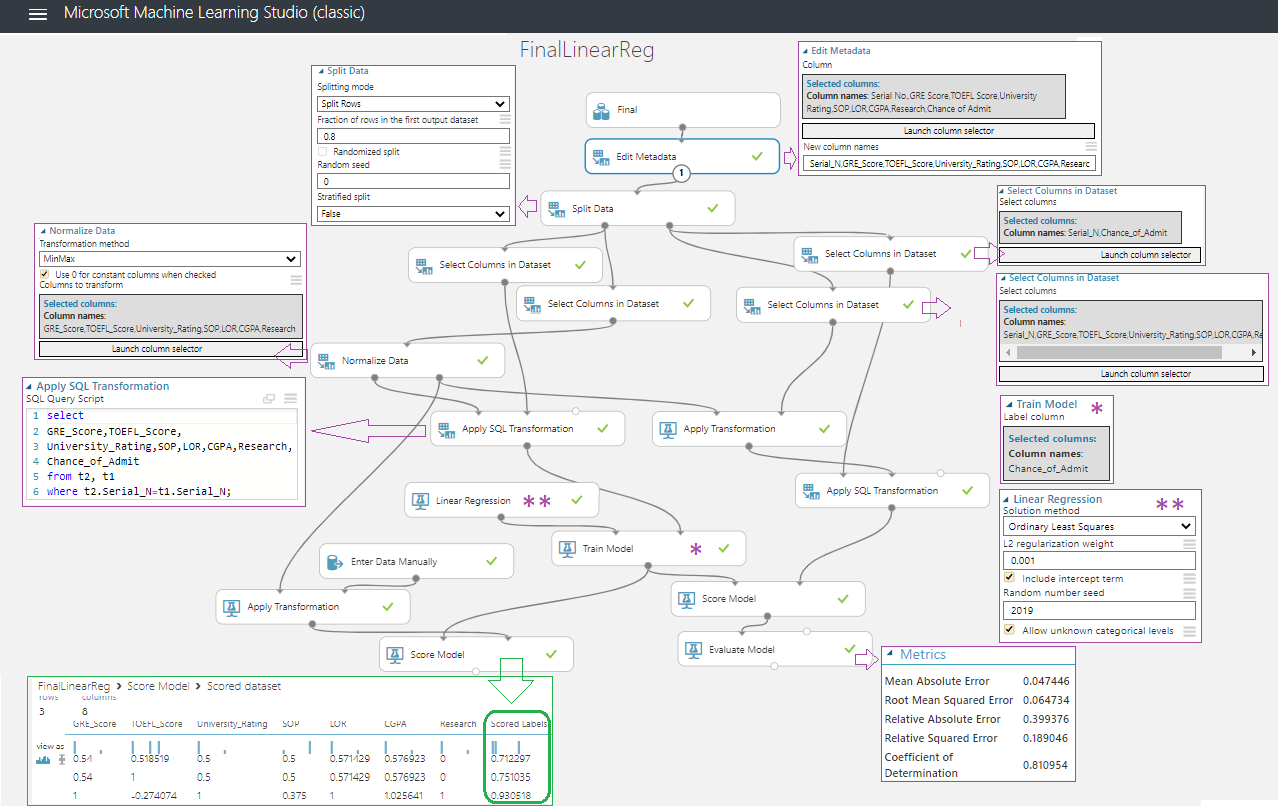

In [24]:
# подключаем модель линейной регрессии
from sklearn.linear_model import LinearRegression

In [25]:
x=csv[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research']]
x=np.array(x) # Предикторы

y=csv['Chance of Admit ']
y=np.array(y) #Отклики

my_LinearRegression = LinearRegression().fit(x, y) # обучение модели

In [26]:
my_LinearRegression.intercept_# коэффициент Фи0

-1.2594324782480142

In [27]:
my_LinearRegression.coef_# коэффициенты Фи1-Фи7

array([ 0.00173741,  0.00291958,  0.00571666, -0.00330517,  0.02235313,
        0.11893945,  0.02452511])

In [28]:
my_colors=[]
for c in my_LinearRegression.coef_:
    if c > 0:
        my_colors.append('blue')
    else:
        my_colors.append('red')
my_colors

['blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue']

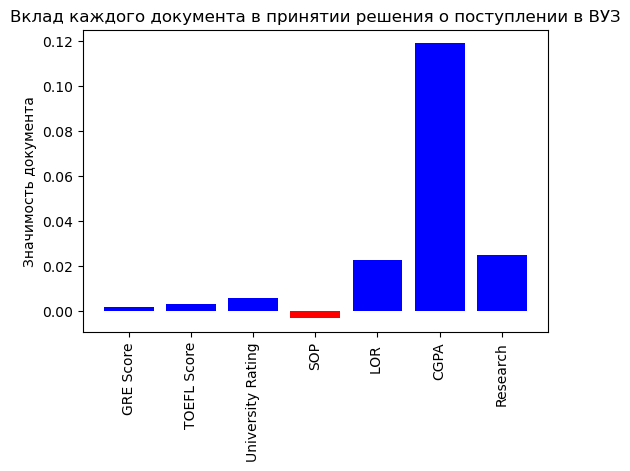

In [29]:
xplot=csv[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research']].columns
yplot=my_LinearRegression.coef_
plt.bar(xplot,yplot, color=my_colors)
plt.title('Вклад каждого документа в принятии решения о поступлении в ВУЗ')
plt.xticks(rotation='vertical')
plt.ylabel('Значимость документа')
plt.show()


## Выводы следующие: 

Наибольший вклад в приятие решение о зачислении дает "Совокупный средний балл бакалавра CGPA". Это своего рода показатель того, что ученик на протяджении всей учебы не отлынивал, а упорно и методично трудился.

Второе, на что ВУЗы обращают внимание, это практические навыки (Опыт исследований Research), и как следствие - рекомендательные письма. Тем самым доказывается, что студент не просто сдавал школьные экзамены и благополучно все забыл, но прменил это на практике. 

Что касается баллов по GRE и TOEFL (значения которых на порядок выше, чем у остальных признаков), их вес в общей оценке значительно ниже.

Заявление о цели обучения SOP вообще имеет отрицательный вес. То, что пишут про себя сами абитуриенты, возможно в дальнейшем не подтверждается на практике. Так что надо писать SOP короктко, лаконично, без патетики. 

#### Используюя метод линейной регресси предскажем вероятность поступления ВУЗ нижеследующих абитуриентов. При оценке полученных значений вероятностей мы будем ориентироваться на средние значения веротяностей построенных ранее кластеров.

 - 1) вероятность поступления в ВУЗ среденстатистического абитуриента (All=MEAN).

In [30]:
csv.mean()

GRE Score            316.807500
TOEFL Score          107.410000
University Rating      3.087500
SOP                    3.400000
LOR                    3.452500
CGPA                   8.598925
Research               0.547500
Chance of Admit        0.724350
Y                      1.177500
dtype: float64

In [31]:
y_predicted1=my_LinearRegression.predict([[317,107,3,3,3.5,8.6,0]])
y_predicted1 # Вероятность поступления 0.71 - сомнительная

array([0.71207142])

Вероятность поступления среденстатистического студента (All=MEAN) сомнительна и состалвяет 0,71.

-  2) вероятность поступления в ВУЗ среднего абитуриента-гуманитраия (All=MEAN,TOEFL=max):

In [32]:
y_predicted2=my_LinearRegression.predict([[317,120,3,3,3.5,8.6,0]])
y_predicted2 # Вероятность поступления 0.75 - сомнительная

array([0.75002592])

Вероятность поступления среднего абитуриента-гуманитраия (All=MEAN,TOEFL=max) хоть и чуть выше, но также сомнительна и состалвяет 0,75. Это наглядно показывает, что баллы по TOEFL имеют незначительный вес при прочих равных условиях.

-  3) вероятность поступления в ВУЗ иностранного абитуриента-гения без особого знания языка (All=MAX,TOEFL=MEAN):

In [33]:
y_predicted3=my_LinearRegression.predict([[340,107*0.8,5,2.5,5,10,1]])
y_predicted3

array([0.92720888])

Вероятность поступления абитуриента-гения без особого знания языка (All=MAX,TOEFL=MEAN) весьма значительная.

Для того, чтобы  пройти порог в 92% вероятности (среднее для кластера  № 3 "ДА") ему достаточно сдавть TOEFL на 20% ниже (107*0.8), чем это делает стреднестатистический абитуриент (TOEFL=107).

Проверим насколько хороша посроенная нами модель линейной регрессии на наших исходных данных.

In [34]:
y_predicted = my_LinearRegression.predict(x)
metrics.r2_score(y, y_predicted)

0.8034713719824393

У нас модель получилась неплохой (F-мера = 0.803), но не идеалной. 

Модель считатся "хорошо-построенной" при оценке больше 0.9, поэтому будем изучат наши данные дальше.

### Задача № 3 - построить модель, с помощью которой мы могли бы предсказывать по совокупности имеющихся параметров к какому классу относится абитуриент.

Деление на классы мы провели в кластерном анализе (метод KMeans).

#### Построим модель логистической регерссии для предсказания

In [35]:
import warnings
warnings.filterwarnings('ignore')

# подключение модели логистической регрессии из библиотеки sklearn
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

В качестве отклка  мы берм не вероятность 'Chance of Admit ', а номер класстера 'Y', потому что просто предсказав вероятность, например, равную  0,85 абитуринету сложно понять: много это или мало.

Надо ли абитуриенту понижать уровень ВУЗа чтобы "наверняка" поступить "хоть в какой-то ВУЗ"? Или все таки попытаться подать заявление на престижные места?

Надо ли родителям абитуриента тратить деньги и нервы на дополнительную подготовкку в вуз (особенно остро это касается тех, кто попадает в сомнительные 0-й и 1-й кластеры)? 

Или же расслабиться (2-й кластер) и спокойно пойти в проф. тех. колледж на востребованные рабочие профессии?

In [36]:
x = pd.DataFrame(csv.drop(['Chance of Admit ', 'Y'], axis=1)) # предикторы
y = pd.DataFrame(csv['Y']) # отклик 

# Разделим наши данные: обучение модели будем проводить на 80% данных
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=False, random_state=0)

# Выполним линейную нормировку
stand = preprocessing.MinMaxScaler(copy=False)
x_train_norm = stand.fit_transform(x_train)

In [37]:
# Обучение модели логистическо регрессии
my_LogisticRegression = LogisticRegression(random_state=2019, solver='lbfgs',max_iter=2000,).fit(x_train_norm, y_train.values.ravel())

In [38]:
x_test_norm=stand.transform(x_test)

# предсказание класса с помощью обученной модели логистичекой регрессии
y_pred = my_LogisticRegression.predict(x_test_norm)

# предсказание вероятности отнесения к классам 0,1,2,3 объектов тестовых данных
y_pred_probs = my_LogisticRegression.predict_proba(x_test_norm)

# отбор отклика Y из тестовых данных = y_test 
y_test.values.T.ravel()

array([1, 0, 1, 2, 1, 0, 2, 2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 3, 0, 0, 1, 0,
       1, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 2, 1, 0, 0, 3, 3, 1,
       1, 3, 0, 1, 2, 2, 1, 0, 3, 0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 2, 3, 3,
       2, 1, 2, 0, 1, 1, 0, 1, 0, 0, 0, 3, 1, 3])

Точность прогнозированя нашей модлеи логистической регрессии отобразим с помощью Матрицы неточностей (Confusion Matrix)

Text(45.722222222222214, 0.5, 'Истинные')

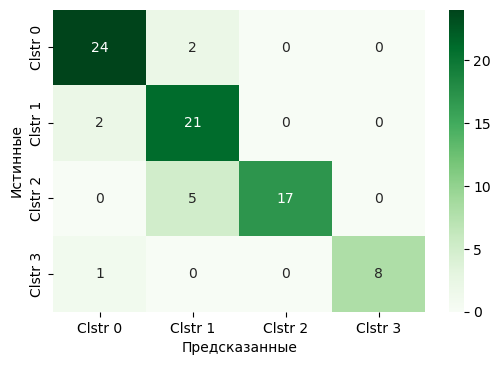

In [39]:
cm=metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="Greens", annot=True, 
            #cbar_kws={'orientation':'vertical','label':'colorbar'},
            xticklabels=['Clstr 0','Clstr 1','Clstr 2','Clstr 3'],
            yticklabels=['Clstr 0','Clstr 1','Clstr 2','Clstr 3']
           )
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')

Вывод: 

Из графика видим, что ошбики классиификации у кластеров № 3 "ДА", № 0 "сомнительно ДА" и №1 "сомнительно НЕТ" незначительны.


Самый большой процент ошибок (23%, 5 ед. из 22(17+5)) мы видим у последнего кластера № 2 "скореее НЕТ".


Поэтому надо особо быть внимательным тем абитуриентам, которые "предсказались" как 1-й класс, а они на самом деле должны быть во 2-м классе: у них могут сформироваться "завышенные ожидания".

Полученные оценки модели логистической регрессии: 
 - Recall - доля истинно положительных (среди других)
 - f1-score каждой метрики cреди других метрик 
 - f1-score средняя = 0.8855 и средневзвешанная = 0.8767
 - accuracy - доля правильных ответов = 0.875

In [40]:
print(metrics.classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8889    0.9231    0.9057        26
           1     0.7500    0.9130    0.8235        23
           2     1.0000    0.7727    0.8718        22
           3     1.0000    0.8889    0.9412         9

    accuracy                         0.8750        80
   macro avg     0.9097    0.8744    0.8855        80
weighted avg     0.8920    0.8750    0.8767        80



Вывод - посроенная модель логистической регресси на основе 4 классов в целом показала хорошую оценку (F-мера)

Среняя F1-score равна 0.8855 avg(f1-score), так и средневзвешенная F1-score=0.8767.


f1-score отнесения к каждому кластеру также велики, особенно у кластеров № 3 и № 0.

Однако учитывая низкий покзатель Recall доли истинно положительных (среди других) значений у кластера № 2 "НЕТ" (0.77), возможно:
- его надо его исследовать дополнительно/отдельно,
- вводить бОльшее количество кластеров.


#### Используюя метод логистической регресси предскажем, к какой "группе вероятности" (кластеру) отностится тот или иной абитуриент:

- 1) вероятность поступления в ВУЗ среденстатистического абитуриента (All=MEAN()):

In [41]:
result=[my_LogisticRegression.predict_proba([stand.transform([[317,107,3,3,3.5,8.6,0]])[0]]),
        my_LogisticRegression.predict      ([stand.transform([[317,107,3,3,3.5,8.6,0]])[0]])
       ]
result # абитуриент отнесен к классу № 1 "скорее НЕТ" 

[array([[0.25432233, 0.64203403, 0.09305268, 0.01059095]]), array([1])]

Вероятность поступления среденстатистического студента (All=MEAN) сомнительна "скорее НЕТ".

-  2) вероятность поступления в ВУЗ среднего абитуриента-гуманитраия (All=MEAN,TOEFL=max):

In [42]:
result=[my_LogisticRegression.predict_proba([stand.transform([[317,120,3,3,3.5,8.6,0]])[0]]),
        my_LogisticRegression.predict      ([stand.transform([[317,120,3,3,3.5,8.6,0]])[0]])
       ]
result # абитуриент отнесен к классу № 1 "скорее НЕТ" 

[array([[0.43420497, 0.45228307, 0.02946964, 0.08404232]]), array([1])]

Итоговая максимальная вероятность у этого абитуриента поступить в ВУЗ соответствует классу № 1 "скорее НЕТ". 

Но здесь ситуация отличается от предыдущего абитуриента - вероятность попасть в класс повыше № 0 "скорее ДА" у него все же есть, если он немного "подтянется" (0.434 против 0.452).

-  3) вероятность поступления в ВУЗ иностранного абитуриента-гения без особого знания языка (All=MAX,TOEFL=MEAN):

In [43]:
result=[my_LogisticRegression.predict_proba([stand.transform([[340,107,5,2.5,5,10,1]])[0]]),
        my_LogisticRegression.predict      ([stand.transform([[340,107,5,2.5,5,10,1]])[0]])
       ]
result

[array([[4.70669622e-01, 2.48097362e-02, 2.65932371e-04, 5.04254710e-01]]),
 array([3])]

Максимальная вероятность у этого абитурента поступить в ВУЗ соответсвует классу № 3 "ДА" 

Причем в рамках логистической модели (в отличие от линейной) этому абитуриенту нельзя расслабляться на TOEFL: чтобы попасть с вероятность чуть более 50% в класс лидеров № 3 "ДА" его балл по TOEFL должен быть не меньше сренего.

Иначе, получив за TOEFL хоть на пол-балла ниже среднего значения, абитуриент-гений проваливается классом ниже - № 0 "скорее ДА".

In [44]:
result=[my_LogisticRegression.predict_proba([stand.transform([[340,106.4,5,2.5,5,10,1]])[0]]),
        my_LogisticRegression.predict      ([stand.transform([[340,106.4,5,2.5,5,10,1]])[0]])
       ]
result

[array([[4.86964787e-01, 2.67391595e-02, 2.97386819e-04, 4.85998666e-01]]),
 array([0])]